# Imports

In [1]:
import pandas
import numpy
import pickle

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, LinearRegression, PoissonRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss, matthews_corrcoef
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error

# Load Data

In [23]:
path = '/content/drive/MyDrive/Colab Notebooks/QMIND_2023-2024/'
file_names = {2015: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015_20240223.csv',
              2016: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016_20240223.csv',
              2017: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017_20240223.csv',
              2018: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2018_20240223.csv',
              2019: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2019_20240203.csv'
             }

columns_to_keep = ['Age Group', 'Gender', 'Race', 'Ethnicity', 'Length of Stay',
                   'Type of Admission', 'APR MDC Description', 'APR Severity of Illness Description',
                   'APR Risk of Mortality', 'APR Medical Surgical Description']

df = []
for year, file_name in file_names.items():
    # Load data and only keep relevant columns
    df_temp = pandas.read_csv(path + file_name, low_memory=False)[columns_to_keep]

    # Drop rows with NA/NULL values
    df_temp = df_temp.dropna().reset_index(drop=True)

    # Drop rows with infrequent or unknown values
    df_temp = df_temp[df_temp['Gender'] != 'U']
    df_temp = df_temp[df_temp['Type of Admission'] != 'Not Available']
    df_temp = df_temp[df_temp['APR Medical Surgical Description'] != 'Not Applicable']
    df_temp = df_temp[~df_temp['APR MDC Description'].isin(['PRE MDC', 'Pre-MDC or Ungroupable'])]

    # Drop duplicate rows
    df_temp = df_temp.drop_duplicates(ignore_index=True)

    # Remove rows with length of stay of "120 +"
    df_temp = df_temp[df_temp['Length of Stay'] != '120 +']
    df_temp['Length of Stay'] = df_temp['Length of Stay'].astype(int)

    df.append(df_temp)
    del(df_temp)

df = pandas.concat(df, ignore_index=True)

# Drop duplicate rows
df = df.drop_duplicates(ignore_index=True)

display(df)

,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR MDC Description,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Length of Stay - Multi-class v1,Length of Stay - Multi-class v2,Length of Stay - Binary v1,Length of Stay - Binary v2,Length of Stay - Binary v3
0,70 or Older,F,White,Not Span/Hispanic,4,Urgent,diseases and disorders of the respiratory system,Moderate,Minor,Medical,1,1,0,0,0
1,70 or Older,F,White,Not Span/Hispanic,4,Elective,"endocrine, nutritional and metabolic diseases ...",Moderate,Moderate,Medical,1,1,0,0,0
2,70 or Older,F,White,Not Span/Hispanic,4,Urgent,diseases and disorders of the respiratory system,Minor,Minor,Medical,1,1,0,0,0
3,50 to 69,F,White,Not Span/Hispanic,2,Elective,diseases and disorders of the digestive system,Moderate,Minor,Medical,1,1,0,0,0
4,70 or Older,M,White,Not Span/Hispanic,2,Elective,diseases and disorders of the respiratory system,Minor,Moderate,Medical,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743885,50 to 69,M,White,Not Span/Hispanic,20,Urgent,diseases and disorders of the musculoskeletal ...,Moderate,Minor,Surgical,3,3,1,1,1
743886,30 to 49,F,White,Not Span/Hispanic,23,Urgent,diseases and disorders of the hepatobiliary sy...,Moderate,Minor,Medical,3,3,1,1,1
743887,70 or Older,M,White,Not Span/Hispanic,28,Urgent,diseases and disorders of the circulatory system,Minor,Minor,Surgical,3,3,1,1,1
743888,18 to 29,M,Black/African American,Not Span/Hispanic,7,Urgent,"poisonings, toxic effects, other injuries and ...",Moderate,Minor,Medical,2,2,1,0,0


# Data Exploration

In [24]:
# Fix inconsistencies in description column
df['APR MDC Description'] = df['APR MDC Description'].str.lower()
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'infectious and parasitic diseases, systemic or unspecified sites',
                                        'infectious and parasitic diseases (systemic or unspecified sites)', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'factors influencing health status and other contacts with health services',
                                        'rehabilitation, aftercare, other factors influencing health status and other health service contacts', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of the musculoskeletal system and conn tissue',
                                        'diseases and disorders of the musculoskeletal system and connective tissue', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of the ear, nose, mouth and throat',
                                        'ear, nose, mouth, throat and craniofacial diseases and disorders', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of blood, blood forming organs and immunological disorders',
                                        'diseases and disorders of the blood and blood forming organs and immunological disorders', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'injuries, poisonings and toxic effects of drugs',
                                        'poisonings, toxic effects, other injuries and other complications of treatment', df['APR MDC Description'])

In [25]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743890 entries, 0 to 743889
Data columns (total 15 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   Age Group                            743890 non-null  object
 1   Gender                               743890 non-null  object
 2   Race                                 743890 non-null  object
 3   Ethnicity                            743890 non-null  object
 4   Length of Stay                       743890 non-null  int64 
 5   Type of Admission                    743890 non-null  object
 6   APR MDC Description                  743890 non-null  object
 7   APR Severity of Illness Description  743890 non-null  object
 8   APR Risk of Mortality                743890 non-null  object
 9   APR Medical Surgical Description     743890 non-null  object
 10  Length of Stay - Multi-class v1      743890 non-null  int64 
 11  Length of Stay - Multi-cla

In [26]:
df.describe(include='all')

,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR MDC Description,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Length of Stay - Multi-class v1,Length of Stay - Multi-class v2,Length of Stay - Binary v1,Length of Stay - Binary v2,Length of Stay - Binary v3
count,743890,743890,743890,743890,743890.000000,743890,743890,743890,743890,743890,743890.000000,743890.000000,743890.000000,743890.000000,743890.000000
unique,5,2,4,4,NaN,5,26,4,4,2,NaN,NaN,NaN,NaN,NaN
top,50 to 69,M,White,Not Span/Hispanic,NaN,Emergency,diseases and disorders of the nervous system,Major,Minor,Medical,NaN,NaN,NaN,NaN,NaN
freq,227372,379248,279490,449697,NaN,417040,67977,260153,240995,459902,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,15.225908,NaN,NaN,NaN,NaN,NaN,2.214161,1.955801,0.670092,0.567173,0.451178
std,NaN,NaN,NaN,NaN,17.544997,NaN,NaN,NaN,NaN,NaN,0.843185,0.848878,0.470180,0.495468,0.497611
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,1.000000,1.000000,0.000000
75%,NaN,NaN,NaN,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,3.000000,3.000000,1.000000,1.000000,1.000000


In [27]:
for column in df.columns:
    print(column)
    print(df[column].value_counts(dropna=False))
    print()

Age Group
50 to 69       227372
70 or Older    191561
30 to 49       151276
0 to 17         90015
18 to 29        83666
Name: Age Group, dtype: int64

Gender
M    379248
F    364642
Name: Gender, dtype: int64

Race
White                     279490
Other Race                246514
Black/African American    172701
Multi-racial               45185
Name: Race, dtype: int64

Ethnicity
Not Span/Hispanic    449697
Spanish/Hispanic     160627
Unknown              111107
Multi-ethnic          22459
Name: Ethnicity, dtype: int64

Length of Stay
2      51710
1      51612
3      50800
4      47719
5      43574
       ...  
114      185
117      177
118      175
116      171
115      163
Name: Length of Stay, Length: 119, dtype: int64

Type of Admission
Emergency    417040
Elective     161072
Urgent       131747
Trauma        20960
Newborn       13071
Name: Type of Admission, dtype: int64

APR MDC Description
diseases and disorders of the nervous system                                              

<Axes: ylabel='Frequency'>

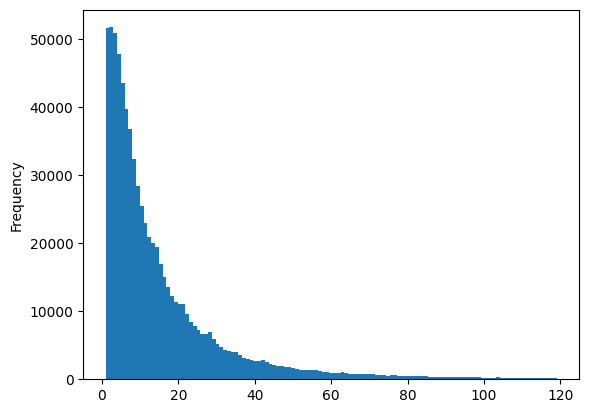

In [28]:
# Plot length of stay
df[df['Length of Stay'] != '120 +']['Length of Stay'].astype(int).plot.hist(bins=119)

# Data Preparation/Processing

In [29]:
# Combine length of stay into multi-class categories (v1)
target_classes_multiclass_v1 = ['1-4 days', '5-9 days', '10-119 days']
lim_1 = 5
lim_2 = 10
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim_1))), 1, df['Length of Stay'])
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay - Multi-class v1'].isin(list(range(lim_1, lim_2))), 2, df['Length of Stay - Multi-class v1'])
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay - Multi-class v1'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim_2)))), 3, df['Length of Stay - Multi-class v1'])
df['Length of Stay - Multi-class v1'].value_counts()

3    361153
1    201841
2    180896
Name: Length of Stay - Multi-class v1, dtype: int64

In [30]:
# Combine length of stay into multi-class categories (v2)
target_classes_multiclass_v2 = ['1-6 days', '7-14 days', '15-119 days']
lim_1 = 7
lim_2 = 15
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim_1))), 1, df['Length of Stay'])
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay - Multi-class v2'].isin(list(range(lim_1, lim_2))), 2, df['Length of Stay - Multi-class v2'])
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay - Multi-class v2'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim_2)))), 3, df['Length of Stay - Multi-class v2'])
df['Length of Stay - Multi-class v2'].value_counts()

1    285187
3    252308
2    206395
Name: Length of Stay - Multi-class v2, dtype: int64

In [34]:
# Combine length of stay into binary categories (v1)
target_classes_binary_v1 = ['1-7 days', '8-119 days']
lim = 8
df['Length of Stay - Binary v1'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v1'] = numpy.where(df['Length of Stay - Binary v1'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v1'])
df['Length of Stay - Binary v1'].value_counts()

1    421914
0    321976
Name: Length of Stay - Binary v1, dtype: int64

In [36]:
# Combine length of stay into binary categories (v2)
target_classes_binary_v2 = ['1-9 days', '10-119 days']
lim = 10
df['Length of Stay - Binary v2'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v2'] = numpy.where(df['Length of Stay - Binary v2'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v2'])
df['Length of Stay - Binary v2'].value_counts()

0    382737
1    361153
Name: Length of Stay - Binary v2, dtype: int64

In [37]:
# Combine length of stay into binary categories (v3)
target_classes_binary_v3 = ['1-10 days', '11-119 days']
lim = 11
df['Length of Stay - Binary v3'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v3'] = numpy.where(df['Length of Stay - Binary v3'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v3'])
df['Length of Stay - Binary v3'].value_counts()

0    408263
1    335627
Name: Length of Stay - Binary v3, dtype: int64

In [38]:
# Split into training and testing subsets
X = df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3'])
y_multiclass_v1 = df['Length of Stay - Multi-class v1']
y_multiclass_v2 = df['Length of Stay - Multi-class v2']
y_binary_v1 = df['Length of Stay - Binary v1']
y_binary_v2 = df['Length of Stay - Binary v2']
y_binary_v3 = df['Length of Stay - Binary v3']
y_regression = df['Length of Stay']
X_train, X_test, y_multiclass_v1_train, y_multiclass_v1_test, y_multiclass_v2_train, y_multiclass_v2_test, y_binary_v1_train, y_binary_v1_test, y_binary_v2_train, y_binary_v2_test, y_binary_v3_train, y_binary_v3_test, y_regression_train, y_regression_test = train_test_split(X, y_multiclass_v1, y_multiclass_v2, y_binary_v1, y_binary_v2, y_binary_v3, y_regression, test_size=0.2, random_state=0, stratify=y_regression)
print('Training:', len(X_train))
print('Testing:', len(X_test))

Training: 595112
Testing: 148778


In [39]:
# One-hot encode categorical features

for column in X_train.columns:
    for value in numpy.unique(df[column]):
        X_train[column + ' - ' + value] = numpy.where(X_train[column] == value, 1, 0)
        X_test[column + ' - ' + value] = numpy.where(X_test[column] == value, 1, 0)

# Drop original columns
X_train = X_train.drop(columns=df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3']).columns)
X_test = X_test.drop(columns=df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3']).columns)

# Print number of columns after one-hot encoding
print('Number of columns after one-hot encoding:', X_train.shape[1])

Number of columns after one-hot encoding: 56


# Training and Testing Functions

In [20]:
def train_and_test_classification(y_train, y_test, mode, target_names):
    models = {'BernoulliNB': BernoulliNB(), 'LogisticRegression': LogisticRegression(max_iter=500), 'MLPClassifier': MLPClassifier(max_iter=500),
              'DecisionTreeClassifier': DecisionTreeClassifier(), 'RandomForestClassifier': RandomForestClassifier()}

    for model_name, model in models.items():
        print(model_name)

        # Training
        model = model.fit(X_train, y_train)

        # Testing
        classifications = model.predict(X_test)
        probabilities = model.predict_proba(X_test)

        # Evaluation
        print(confusion_matrix(y_test, classifications))
        print()
        print(classification_report(y_test, classifications, target_names=target_names))
        print('Accuracy: ', round(accuracy_score(y_test, classifications), 4))
        if mode == 'Multi-Class':
            print('Recall:   ', round(recall_score(y_test, classifications, average='macro'), 4))
            print('Precision:', round(precision_score(y_test, classifications, average='macro'), 4))
            print('F1:       ', round(f1_score(y_test, classifications, average='macro'), 4))
            print('AU_ROC:   ', round(roc_auc_score(y_test, probabilities, multi_class='ovr'), 4))
            print('Log loss: ', round(log_loss(y_test, probabilities), 4))
        elif mode == 'Binary':
            print('Recall:   ', round(recall_score(y_test, classifications), 4))
            print('Precision:', round(precision_score(y_test, classifications), 4))
            print('F1:       ', round(f1_score(y_test, classifications), 4))
            print('AU_ROC:   ', round(roc_auc_score(y_test, probabilities[:,1]), 4))
            print('Log loss: ', round(log_loss(y_test, probabilities[:,1]), 4))
        print('MCC:      ', round(matthews_corrcoef(y_test, classifications), 4))

        print()

    return models

In [21]:
def train_and_test_regression(y_train, y_test):
    models = {'LinearRegression': LinearRegression(), 'MLPRegressor': MLPRegressor(max_iter=500),
              'DecisionTreeRegressor': DecisionTreeRegressor(), 'RandomForestRegressor': RandomForestRegressor()}

    for model_name, model in models.items():
        print(model_name)

        # To ensure positive: https://stackoverflow.com/questions/26897981/restrict-the-predictions-from-sgdregressor-in-scikit-learn-to-positive-values

        # Training
        model = model.fit(X_train, numpy.log(y_train))

        # Testing
        predictions = numpy.exp(model.predict(X_test))
        classifications = numpy.round(predictions)

        # Evaluation (regression)
        print('R2:                   ', round(r2_score(y_test, predictions), 4))
        print('Mean absolute error:  ', round(mean_absolute_error(y_test, predictions), 4))
        print('Median absolute error:', round(median_absolute_error(y_test, predictions), 4))
        print('Mean squared error:   ', round(mean_squared_error(y_test, predictions), 4))

        # Evaluation (classification)
        print('Accuracy:             ', round(accuracy_score(y_test, classifications), 4))
        print('Recall:               ', round(recall_score(y_test, classifications, average='macro'), 4))
        print('Precision:            ', round(precision_score(y_test, classifications, average='macro'), 4))
        print('F1:                   ', round(f1_score(y_test, classifications, average='macro'), 4))
        print('MCC:                  ', round(matthews_corrcoef(y_test, classifications), 4))

        print()

    return models

# Training and Testing (Multiclass)

In [40]:
models_multiclass_v1 = train_and_test_classification(y_multiclass_v1_train, y_multiclass_v1_test, 'Multi-Class', target_classes_multiclass_v1)

BernoulliNB
[[23396  1780 15192]
 [15468  2026 18685]
 [15401  2261 54569]]

              precision    recall  f1-score   support

    1-4 days       0.43      0.58      0.49     40368
    5-9 days       0.33      0.06      0.10     36179
 10-119 days       0.62      0.76      0.68     72231

    accuracy                           0.54    148778
   macro avg       0.46      0.46      0.42    148778
weighted avg       0.50      0.54      0.49    148778

Accuracy:  0.5377
Recall:    0.4637
Precision: 0.4607
F1:        0.4232
AU_ROC:    0.6761
Log loss:  0.9994
MCC:       0.2465

LogisticRegression
[[21320   152 18896]
 [13163   176 22840]
 [ 9228   146 62857]]

              precision    recall  f1-score   support

    1-4 days       0.49      0.53      0.51     40368
    5-9 days       0.37      0.00      0.01     36179
 10-119 days       0.60      0.87      0.71     72231

    accuracy                           0.57    148778
   macro avg       0.49      0.47      0.41    148778
weigh

In [41]:
models_multiclass_v2 = train_and_test_classification(y_multiclass_v2_train, y_multiclass_v2_test, 'Multi-Class', target_classes_multiclass_v2)

BernoulliNB
[[39368  5140 12529]
 [20770  5602 14907]
 [14441  5070 30951]]

              precision    recall  f1-score   support

    1-6 days       0.53      0.69      0.60     57037
   7-14 days       0.35      0.14      0.20     41279
 15-119 days       0.53      0.61      0.57     50462

    accuracy                           0.51    148778
   macro avg       0.47      0.48      0.45    148778
weighted avg       0.48      0.51      0.48    148778

Accuracy:  0.5103
Recall:    0.4798
Precision: 0.4708
F1:        0.4544
AU_ROC:    0.677
Log loss:  1.0325
MCC:       0.2504

LogisticRegression
[[41875  1844 13318]
 [22682  2093 16504]
 [13671  1951 34840]]

              precision    recall  f1-score   support

    1-6 days       0.54      0.73      0.62     57037
   7-14 days       0.36      0.05      0.09     41279
 15-119 days       0.54      0.69      0.61     50462

    accuracy                           0.53    148778
   macro avg       0.48      0.49      0.44    148778
weight

# Training and Testing (Binary)

In [42]:
models_binary_v1 = train_and_test_classification(y_binary_v1_train, y_binary_v1_test, 'Binary', target_classes_binary_v1)

BernoulliNB
[[40032 24363]
 [25796 58587]]

              precision    recall  f1-score   support

    1-7 days       0.61      0.62      0.61     64395
  8-119 days       0.71      0.69      0.70     84383

    accuracy                           0.66    148778
   macro avg       0.66      0.66      0.66    148778
weighted avg       0.66      0.66      0.66    148778

Accuracy:  0.6629
Recall:    0.6943
Precision: 0.7063
F1:        0.7002
AU_ROC:    0.7193
Log loss:  0.6454
MCC:       0.3152

LogisticRegression
[[36784 27611]
 [18585 65798]]

              precision    recall  f1-score   support

    1-7 days       0.66      0.57      0.61     64395
  8-119 days       0.70      0.78      0.74     84383

    accuracy                           0.69    148778
   macro avg       0.68      0.68      0.68    148778
weighted avg       0.69      0.69      0.69    148778

Accuracy:  0.6895
Recall:    0.7798
Precision: 0.7044
F1:        0.7402
AU_ROC:    0.7427
Log loss:  0.5892
MCC:       0.359

In [43]:
models_binary_v2 = train_and_test_classification(y_binary_v2_train, y_binary_v2_test, 'Binary', target_classes_binary_v2)

BernoulliNB
[[53344 23203]
 [27093 45138]]

              precision    recall  f1-score   support

    1-9 days       0.66      0.70      0.68     76547
 10-119 days       0.66      0.62      0.64     72231

    accuracy                           0.66    148778
   macro avg       0.66      0.66      0.66    148778
weighted avg       0.66      0.66      0.66    148778

Accuracy:  0.6619
Recall:    0.6249
Precision: 0.6605
F1:        0.6422
AU_ROC:    0.7251
Log loss:  0.6487
MCC:       0.3227

LogisticRegression
[[53369 23178]
 [24323 47908]]

              precision    recall  f1-score   support

    1-9 days       0.69      0.70      0.69     76547
 10-119 days       0.67      0.66      0.67     72231

    accuracy                           0.68    148778
   macro avg       0.68      0.68      0.68    148778
weighted avg       0.68      0.68      0.68    148778

Accuracy:  0.6807
Recall:    0.6633
Precision: 0.6739
F1:        0.6686
AU_ROC:    0.7492
Log loss:  0.5915
MCC:       0.360

In [44]:
models_binary_v3 = train_and_test_classification(y_binary_v3_train, y_binary_v3_test, 'Binary', target_classes_binary_v3)

BernoulliNB
[[59229 22423]
 [26999 40127]]

              precision    recall  f1-score   support

   1-10 days       0.69      0.73      0.71     81652
 11-119 days       0.64      0.60      0.62     67126

    accuracy                           0.67    148778
   macro avg       0.66      0.66      0.66    148778
weighted avg       0.67      0.67      0.67    148778

Accuracy:  0.6678
Recall:    0.5978
Precision: 0.6415
F1:        0.6189
AU_ROC:    0.7276
Log loss:  0.6434
MCC:       0.3258

LogisticRegression
[[60766 20886]
 [26086 41040]]

              precision    recall  f1-score   support

   1-10 days       0.70      0.74      0.72     81652
 11-119 days       0.66      0.61      0.64     67126

    accuracy                           0.68    148778
   macro avg       0.68      0.68      0.68    148778
weighted avg       0.68      0.68      0.68    148778

Accuracy:  0.6843
Recall:    0.6114
Precision: 0.6627
F1:        0.636
AU_ROC:    0.7517
Log loss:  0.5862
MCC:       0.359


# Training and Testing (Regression)

In [45]:
models_regression = train_and_test_regression(y_regression_train, y_regression_test)

LinearRegression
R2:                    0.1165
Mean absolute error:   9.5659
Median absolute error: 4.9698
Mean squared error:    272.0533
Accuracy:              0.0584
Recall:                0.0117


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:             0.0161
F1:                    0.0102
MCC:                   0.0195

MLPRegressor
R2:                    0.2338
Mean absolute error:   8.9194
Median absolute error: 4.6475
Mean squared error:    235.9261
Accuracy:              0.0661
Recall:                0.0131


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:             0.0172
F1:                    0.0121
MCC:                   0.0275

DecisionTreeRegressor
R2:                    0.1882
Mean absolute error:   9.4932
Median absolute error: 5.2711
Mean squared error:    249.9827
Accuracy:              0.0553
Recall:                0.0115


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:             0.0122
F1:                    0.011
MCC:                   0.017

RandomForestRegressor
R2:                    0.215
Mean absolute error:   9.2997
Median absolute error: 5.1591
Mean squared error:    241.7266
Accuracy:              0.0578
Recall:                0.0119


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:             0.012
F1:                    0.0111
MCC:                   0.0193



# Best models

In [46]:
print(target_classes_multiclass_v1)
model_multiclass = models_multiclass_v1['MLPClassifier']

print(target_classes_binary_v1)
model_binary = models_binary_v1['MLPClassifier']

model_regression = models_regression['MLPRegressor']

pickle.dump(model_multiclass, open(path + 'model_multiclass.sav', 'wb'))
pickle.dump(model_binary, open(path + 'model_binary.sav', 'wb'))
pickle.dump(model_regression, open(path + 'model_regression.sav', 'wb'))

['1-4 days', '5-9 days', '10-119 days']
['1-7 days', '8-119 days']
